In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *


file_path = "results.json"

In [13]:
df = pd.read_json(file_path)
df

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,62.475139,1.77257,"[0.321989417, 0.38485253540000003, 0.386177637...",1701.956661,"[[2.783075669, 2.477402057, 1.3343227776, 1.50...",4.045212,4.029442,92
1,62.475139,1.77257,"[0.1928266046, 0.470241956, 0.3139225734, 0.16...",1706.565815,"[[0.8646469423, 2.0082026625, 1.9600371821, 2....",4.046251,3.982017,82
2,62.475139,1.77257,"[0.33739855420000003, 0.4183864741, 0.33043210...",1706.866548,"[[0.3353279521, 2.1499257892, 1.6806346287, 1....",9.278378,8.421323,72
3,62.475139,1.77257,"[0.3584006831, 0.4903861278, 0.4049078258, 0.4...",1728.353328,"[[2.9672235889, 1.4580074149, 0.60568344660000...",9.147577,7.966420,37
4,62.475139,1.77257,"[0.33739855420000003, 0.4183864741, 0.33043210...",1705.154495,"[[0.3353279521, 2.1499257892, 1.6806346287, 1....",9.278378,8.421323,72
5,62.475139,1.77257,"[0.35381466840000003, 0.1929089465, 0.26437229...",1703.329493,"[[1.5698360062, 0.8040502209, 0.8108470462, 0....",0.376214,0.578930,89
6,62.475139,1.77257,"[0.4437468137, 0.4546729433, 0.4532835658, 0.3...",1708.719492,"[[0.1060435503, 1.5365765538, 2.6580547259, 1....",8.905930,8.022533,62


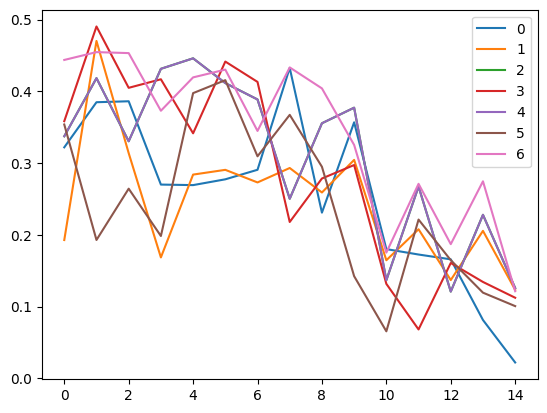

In [4]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

In [6]:
## experimental specific settings
label = 'sigmoid'
nq = 3
n_step = 8

In [12]:

func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]


#############################################################################################
###################################### System Preparatio and _sin_#################
#############################################################################################

lower = 0. 
upper = 1. 
f_i = 0.0 
scaled=False
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
    norm = np.linalg.norm(y)
    y = y / norm

tck=splrep(x,y,k=1) #coeffs
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)


#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################


k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 


beta_classic                 : [ 0.01798621  0.07173906 -0.0502415   0.65973407 -0.0375285   1.14655868
  0.7277244   0.98201379]


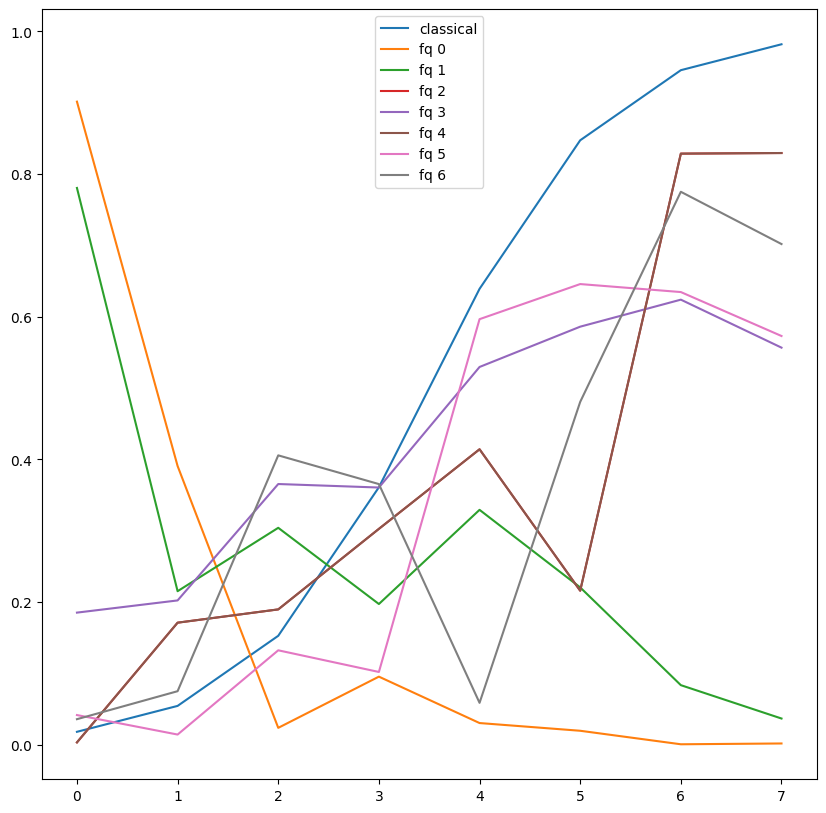

In [19]:
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))

  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq {i}")
plt.legend()

In [24]:
best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]

weights

[2.9497156953,
 0.635333565,
 0.7977561676,
 -0.17856585860000002,
 1.2467189518,
 -0.2250341264,
 0.0678401327,
 1.2679199827,
 1.4328707737]

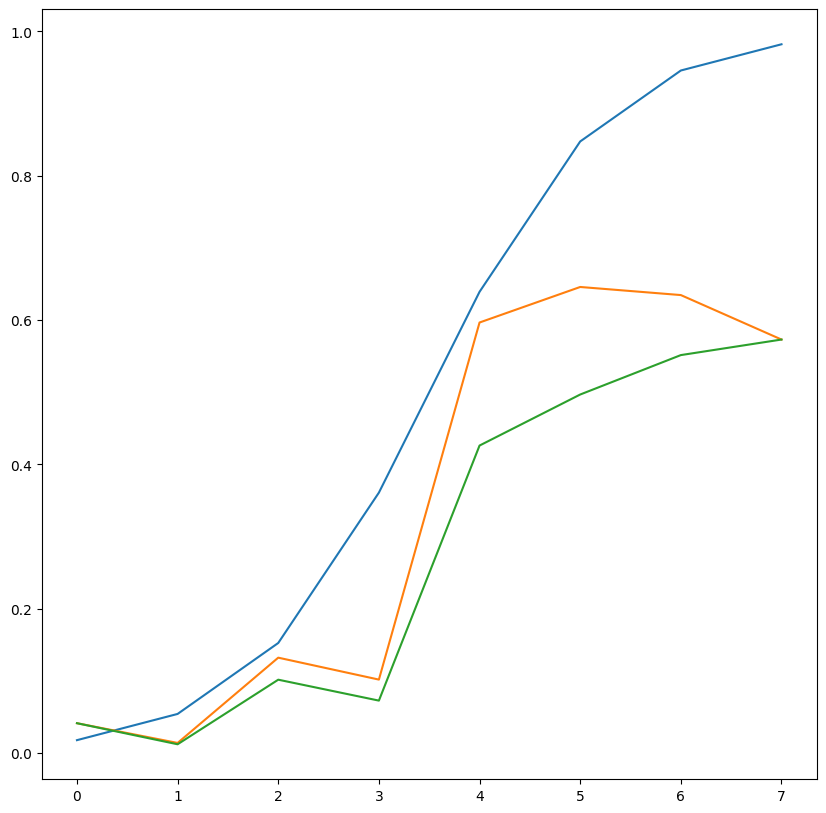

In [26]:
#Best performing model based on RSS

best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq {best}")
plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq {best}")
